In [1]:
import fasttext
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import string
from collections import Counter

2025-04-22 00:31:10.152384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745281870.381014      67 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745281870.444103      67 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load dataset
dsk = pd.read_excel('/kaggle/input/kurdishkdfnd/KDFND_Anlyzed_Cleaned_Filtered_Labeld.xlsx')


In [3]:
dsk.nunique()

ID                            90905
Text                         100961
Text_Translate_to_English    100411
URL                          100800
date                             12
Source                          103
label                             5
Unnamed: 7                        3
dtype: int64

In [4]:
dsk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100966 entries, 0 to 100965
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         100962 non-null  float64
 1   Text                       100962 non-null  object 
 2   Text_Translate_to_English  100961 non-null  object 
 3   URL                        100962 non-null  object 
 4   date                       100962 non-null  object 
 5   Source                     100962 non-null  object 
 6   label                      100965 non-null  object 
 7   Unnamed: 7                 3 non-null       float64
dtypes: float64(2), object(6)
memory usage: 6.2+ MB


In [5]:
# Remove null Rows
dsk = dsk.dropna(subset=['Text_Translate_to_English'])

# Remove columns that not needed
dsk["Article"] = dsk["Text_Translate_to_English"]
dsk['label'] = dsk['label'].map({'Real': 0, 'Fake': 1})  # Convert labels to 0 and 1
dsk = dsk[['Article', 'label']].dropna()

In [6]:
from sklearn.utils import resample
# Assuming 'dsk' is your DataFrame and you have a binary label column called 'label'
# Split the dataset into majority and minority classes
majority_class = dsk[dsk['label'] == 0]
minority_class = dsk[dsk['label'] == 1]

# Perform undersampling on the minority class
majority_undersampled = resample(majority_class,replace=True, n_samples=len(minority_class), random_state=42)  # For reproducibility

# Combine majority class with the undersampled minority class
dskb = pd.concat([minority_class, majority_undersampled])

# Shuffle the dataset
dskb = dskb.sample(frac=1, random_state=42).reset_index(drop=True)
print("Balanced class distribution:")
print(dskb['label'].value_counts())

Balanced class distribution:
label
1    50210
0    50210
Name: count, dtype: int64


In [7]:
# Text Preprocessing

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if isinstance(text, str):
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
        text = re.sub(r'\@\w+|\#', '', text)
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = re.sub(r'\d+', '', text)      # Remove numbers
        text = text.lower().strip()
        words = text.split()
        #words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words or word in ['not', 'never']]
        return ' '.join(words)
    return ''
dskb

,Article,label
0,"17,000 pieces of artifacts will be handed over...",1
1,"Because of the demonstration, no one was arres...",0
2,The Iraqi customs committee has increased its ...,0
3,Other American B52 planes were sent to the Gulf,0
4,The minister of education has been building sc...,0
...,...,...
100415,"A 37-year-old man named Osama Jabbar Mohammed,...",1
100416,"Nuri Maliki, the demonstrators, we are doing y...",0
100417,The world's oil markets have declined and the ...,0
100418,Kurdistan Parliament awards a shepherd for 34 ...,1


In [8]:
dskb['label1'] = "__label__" + dskb['label'].astype(str)

In [9]:
dskb['label_description'] = dskb['label1'].astype(str) + " " + dskb['Article'].astype(str)
dskb

,Article,label,label1,label_description
0,"17,000 pieces of artifacts will be handed over...",1,__label__1,"__label__1 17,000 pieces of artifacts will be ..."
1,"Because of the demonstration, no one was arres...",0,__label__0,"__label__0 Because of the demonstration, no on..."
2,The Iraqi customs committee has increased its ...,0,__label__0,__label__0 The Iraqi customs committee has inc...
3,Other American B52 planes were sent to the Gulf,0,__label__0,__label__0 Other American B52 planes were sent...
4,The minister of education has been building sc...,0,__label__0,__label__0 The minister of education has been ...
...,...,...,...,...
100415,"A 37-year-old man named Osama Jabbar Mohammed,...",1,__label__1,__label__1 A 37-year-old man named Osama Jabba...
100416,"Nuri Maliki, the demonstrators, we are doing y...",0,__label__0,"__label__0 Nuri Maliki, the demonstrators, we ..."
100417,The world's oil markets have declined and the ...,0,__label__0,__label__0 The world's oil markets have declin...
100418,Kurdistan Parliament awards a shepherd for 34 ...,1,__label__1,__label__1 Kurdistan Parliament awards a sheph...


In [10]:
train, test = train_test_split(dskb, test_size = 0.2)

In [11]:
train.to_csv("fake_news_train.txt", columns = ['label_description'], index=False, sep=' ', header=False,
    quoting=3, escapechar=' ', mode='w')
test.to_csv("fake_news_test.txt", columns = ['label_description'], index=False, sep=' ', header=False,
    quoting=3, escapechar=' ', mode='w')

In [12]:
# Train FastText Model
fasttext_model = fasttext.train_supervised(input="fake_news_train.txt", lr=0.5, epoch=25, wordNgrams=2, dim=300)
#y_predic = fasttext_model.test("fake_news_test.txt")

Read 2M words
Number of words:  69428
Number of labels: 2
Progress: 100.0% words/sec/thread:  449363 lr:  0.000000 avg.loss:  0.094815 ETA:   0h 0m 0s


In [13]:
# Function to get FastText vector safely
def fasttext_vector(text):
    if isinstance(text, str):  # Ensure text is a string
        text = text.replace("\n", " ").strip()  # Remove newlines
        return fasttext_model.get_sentence_vector(text)
    return np.zeros(300)  # Return zero vector for empty/non-string values


In [14]:
# Apply FastText vectors to dataset
X_fasttext = np.array([fasttext_vector(text) for text in dskb['Article']])
# Function to get FastText vector
y = np.array(dskb['label'])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_fasttext, y, test_size=0.2, random_state=42)

In [15]:
# Tokenization
max_words = 10000
max_len = 200
# First ensure all articles are strings
dskb['Article'] = dskb['Article'].astype(str)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(dskb['Article'])
X_sequences = tokenizer.texts_to_sequences(dskb['Article'])
X_padded = pad_sequences(X_sequences, maxlen=max_len)


In [16]:
# Embedding Matrix from FastText
embedding_matrix = np.zeros((max_words, 300))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_matrix[i] = fasttext_model.get_word_vector(word)


In [18]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=300, weights=[embedding_matrix], input_length=max_len, trainable=True),
    LSTM(128, return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile & Train
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1745279583.032837     113 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [19]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

y_pred = (model.predict(X_test) > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

Epoch 1/5


I0000 00:00:1745279590.087785     168 cuda_dnn.cc:529] Loaded cuDNN version 90300


1256/1256 ━━━━━━━━━━━━━━━━━━━━ 44s 31ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.4966 - val_loss: 0.6932
Epoch 2/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.5001 - loss: 0.6932 - val_accuracy: 0.5034 - val_loss: 0.6931
Epoch 3/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.5002 - loss: 0.6932 - val_accuracy: 0.5034 - val_loss: 0.6931
Epoch 4/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.4993 - loss: 0.6932 - val_accuracy: 0.4966 - val_loss: 0.6932
Epoch 5/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.4956 - loss: 0.6932 - val_accuracy: 0.4966 - val_loss: 0.6932
628/628 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step
Accuracy: 0.4966
Precision: 0.4966
Recall: 1.0000
F1-Score: 0.6636


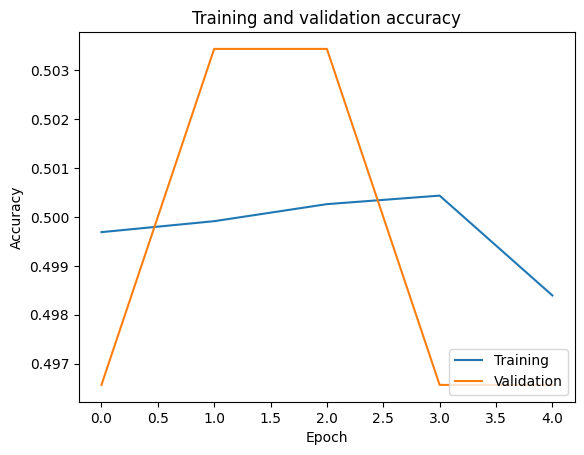

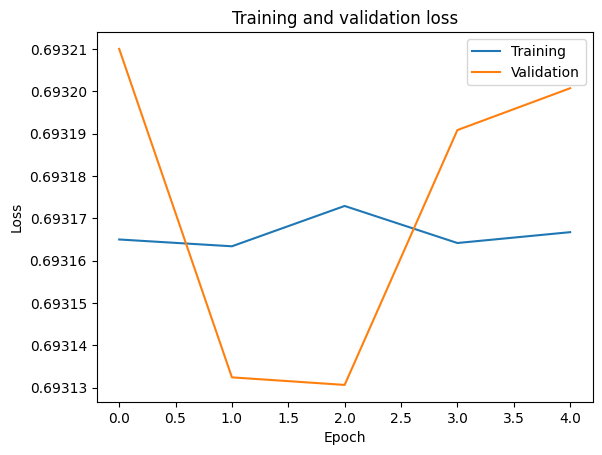

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

**Improved Accuracy and Runtime in model by delete Embedding**

In [21]:
model = Sequential([
    LSTM(128, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile & Train
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

y_pred = (model.predict(X_test) > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

Epoch 1/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - accuracy: 0.7707 - loss: 0.5764 - val_accuracy: 0.9681 - val_loss: 0.1275
Epoch 2/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.9665 - loss: 0.1350 - val_accuracy: 0.9685 - val_loss: 0.1225
Epoch 3/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.9681 - loss: 0.1291 - val_accuracy: 0.9690 - val_loss: 0.1209
Epoch 4/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.9672 - loss: 0.1332 - val_accuracy: 0.9687 - val_loss: 0.1200
Epoch 5/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.9683 - loss: 0.1226 - val_accuracy: 0.9685 - val_loss: 0.1231
628/628 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
Accuracy: 0.9685
Precision: 0.9702
Recall: 0.9663
F1-Score: 0.9683


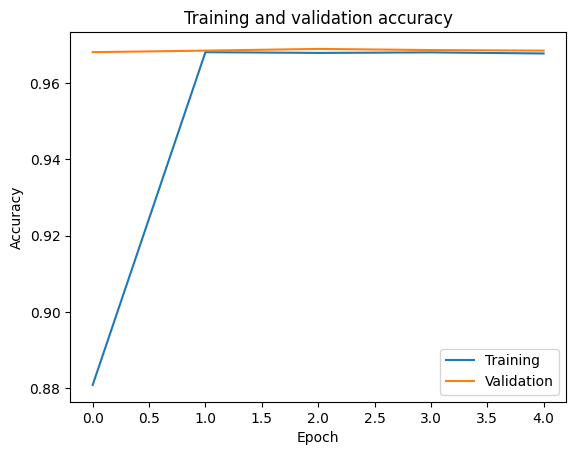

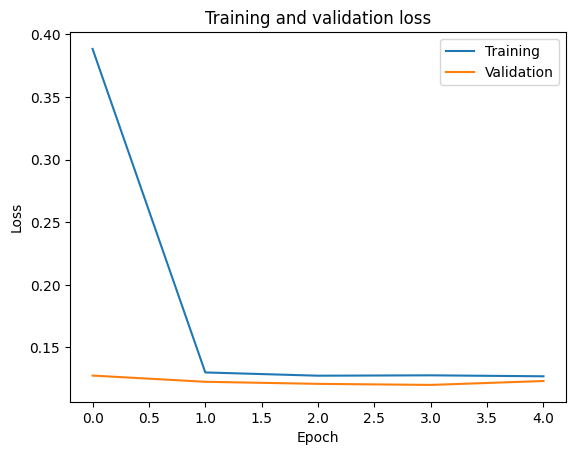

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [17]:
# Assuming X_train is 2D (samples, features)
X_train_sh = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # Add timesteps dimension
X_test_sh = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [19]:
# BiLSTM Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=300, weights=[embedding_matrix], input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-04-22 00:35:38.890384: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [21]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

y_pred = (model.predict(X_test) > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

Epoch 1/3
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 691s 550ms/step - accuracy: 0.4980 - loss: 0.6932 - val_accuracy: 0.5034 - val_loss: 0.6931
Epoch 2/3
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 680s 542ms/step - accuracy: 0.4974 - loss: 0.6932 - val_accuracy: 0.4966 - val_loss: 0.6932
Epoch 3/3
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 685s 545ms/step - accuracy: 0.5037 - loss: 0.6931 - val_accuracy: 0.5034 - val_loss: 0.6931
628/628 ━━━━━━━━━━━━━━━━━━━━ 60s 94ms/step
Accuracy: 0.5034
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

**Improved BiLSTM Accuracy and Runtime in model by Deleting Embedding**

In [22]:
# BiLSTM Model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [23]:
history = model.fit(X_train_sh, y_train, epochs=5, batch_size=64, validation_data=(X_test_sh, y_test))

y_pred = (model.predict(X_test_sh) > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

Epoch 1/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 247s 191ms/step - accuracy: 0.7780 - loss: 0.4751 - val_accuracy: 0.9704 - val_loss: 0.1182
Epoch 2/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 239s 190ms/step - accuracy: 0.9466 - loss: 0.1692 - val_accuracy: 0.9704 - val_loss: 0.1192
Epoch 3/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 262s 190ms/step - accuracy: 0.9499 - loss: 0.1623 - val_accuracy: 0.9701 - val_loss: 0.1187
Epoch 4/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 239s 190ms/step - accuracy: 0.9486 - loss: 0.1615 - val_accuracy: 0.9698 - val_loss: 0.1192
Epoch 5/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 239s 190ms/step - accuracy: 0.9491 - loss: 0.1650 - val_accuracy: 0.9701 - val_loss: 0.1158
628/628 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step
Accuracy: 0.9701
Precision: 0.9691
Recall: 0.9707
F1-Score: 0.9699


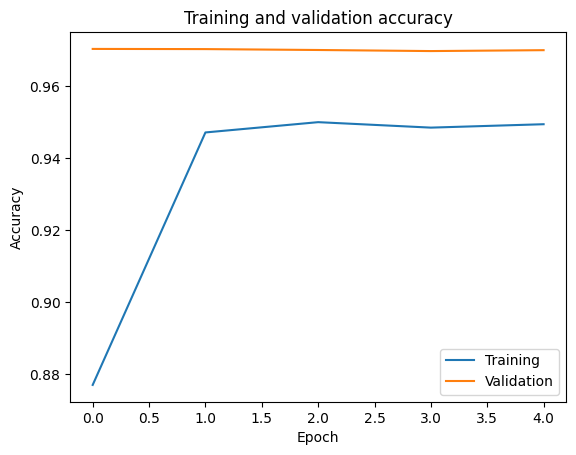

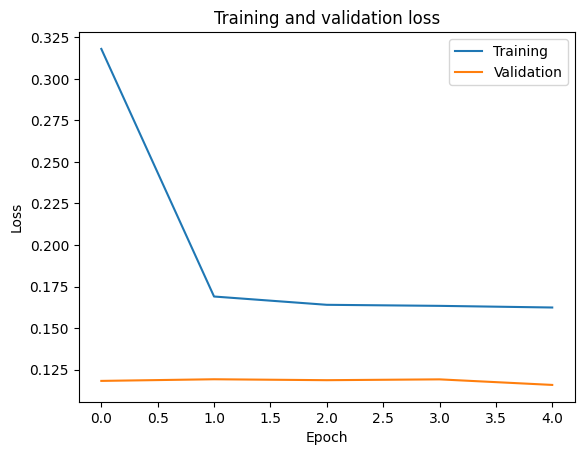

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [48]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=300, weights=[embedding_matrix], input_length=max_len),

    # Reshape input if needed (if not using Embedding) , trainable=True
    # Conv1D + Pooling for feature extraction
    Conv1D(filters=64, kernel_size=3, activation='relu'),  # Removed input_shape (handled by Embedding)
    MaxPooling1D(pool_size=2),
    GlobalMaxPooling1D(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model before fitting
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

In [49]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

y_pred = (model.predict(X_test) > 0.5).astype(int)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

Epoch 1/5


I0000 00:00:1745281330.712848     170 service.cc:148] XLA service 0x7a3e64627750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745281330.715549     170 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   5/1256 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.4703 - loss: 0.6931

I0000 00:00:1745281333.466504     170 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1256/1256 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5024 - loss: 0.6932 - val_accuracy: 0.4966 - val_loss: 0.6932
Epoch 2/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5025 - loss: 0.6932 - val_accuracy: 0.5034 - val_loss: 0.6931
Epoch 3/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4998 - loss: 0.6932 - val_accuracy: 0.4966 - val_loss: 0.6932
Epoch 4/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5030 - loss: 0.6931 - val_accuracy: 0.5034 - val_loss: 0.6931
Epoch 5/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4979 - loss: 0.6932 - val_accuracy: 0.4966 - val_loss: 0.6932
628/628 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.4966
Precision: 0.4966
Recall: 1.0000
F1-Score: 0.6636


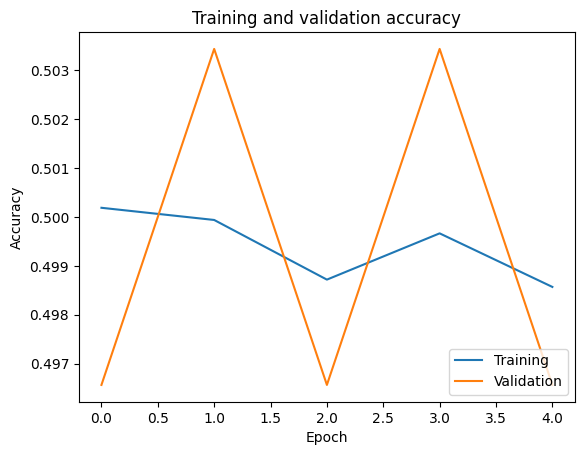

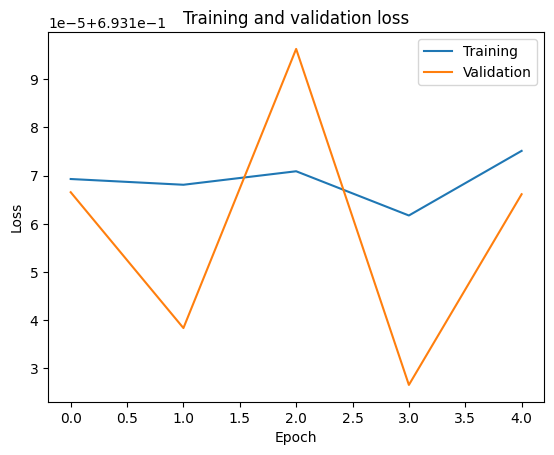

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

**Improved Cnn Accuracy and Runtime in model by Deleting Embedding**

In [51]:

model = Sequential([
    # Reshape input if needed (if not using Embedding)
    # Conv1D + Pooling for feature extraction
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(max_len, 1)),  # Input shape (timesteps, features)
    MaxPooling1D(pool_size=2),
    GlobalMaxPooling1D(),  # Critical for classification!
    # Dense layers for classification
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [52]:

history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

y_pred = (model.predict(X_test) > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

Epoch 1/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7723 - loss: 0.5617 - val_accuracy: 0.9648 - val_loss: 0.1722
Epoch 2/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9556 - loss: 0.1897 - val_accuracy: 0.9653 - val_loss: 0.1406
Epoch 3/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9591 - loss: 0.1683 - val_accuracy: 0.9664 - val_loss: 0.1339
Epoch 4/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9606 - loss: 0.1629 - val_accuracy: 0.9655 - val_loss: 0.1366
Epoch 5/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9600 - loss: 0.1607 - val_accuracy: 0.9669 - val_loss: 0.1311
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.9669
Precision: 0.9630
Recall: 0.9707
F1-Score: 0.9668


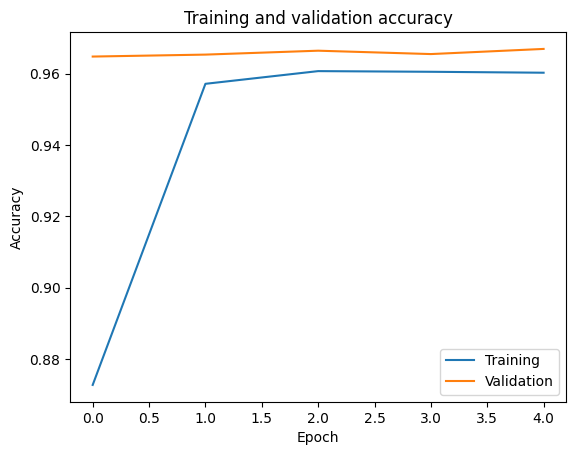

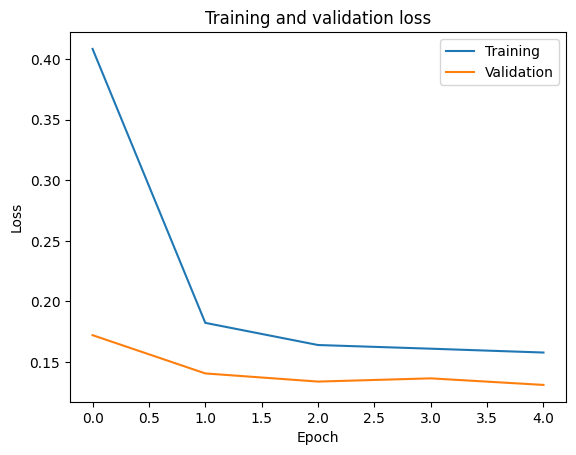

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()